## Read data From our PySpark job

Install plot visual lib:

```bash
source venv/bin/activate
pip3 install matplotlib
```

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

### Read the aggregated data from our Spark Streaming session 
Data generated by our PySpark job: spark-streaming-job-3.py

In [2]:
# Create SparkSession
spark = SparkSession.builder\
             .master("local[1]")\
             .appName("spark-app-version-x")\
             .getOrCreate()

24/04/02 08:40:53 WARN Utils: Your hostname, sasa-1-2 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/04/02 08:40:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/02 08:40:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Let's see the aggregated data now
output_files = '/home/sasa/Code/spark_jobs/output_aggregations/'
df_aggr = spark.read.parquet(output_files)

In [4]:
# DF is like a relation table in memory. Let's see the columns
df_aggr.printSchema()

root
 |-- device_id: string (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg(temperature): decimal(14,4) (nullable = true)



In [5]:
# Query sample:
df_aggr.sort('window','device_id').show(truncate=False)

+---------+------------------------------------------+----------------+
|device_id|window                                    |avg(temperature)|
+---------+------------------------------------------+----------------+
|device_1 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|-0.2692         |
|device_2 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|-0.0714         |
|device_3 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|-0.2500         |
|device_4 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|-0.4091         |
|device_1 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|-1.6923         |
|device_2 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|-0.5652         |
|device_3 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|-0.7083         |
|device_4 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|-0.5926         |
|device_1 |{2024-03-26 18:29:55, 2024-03-26 18:30:00}|-0.2857         |
|device_2 |{2024-03-26 18:29:55, 2024-03-26 18:30:00}|-0.2000         |
|device_3 |{2024-03-26 18:29:55, 2024-03-26 18:30:00}|0.0345    

In [7]:
# Query sample 
df_aggr.select(
        "device_id",
        "window",
        df_aggr.window.start.cast("string").alias("start"),
        df_aggr.window.end.cast("string").alias("end"), 
        "avg(temperature)"
        ).sort('start','device_id').show(truncate=False)

+---------+------------------------------------------+-------------------+-------------------+----------------+
|device_id|window                                    |start              |end                |avg(temperature)|
+---------+------------------------------------------+-------------------+-------------------+----------------+
|device_1 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|2024-03-26 18:29:45|2024-03-26 18:29:50|-0.2692         |
|device_2 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|2024-03-26 18:29:45|2024-03-26 18:29:50|-0.0714         |
|device_3 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|2024-03-26 18:29:45|2024-03-26 18:29:50|-0.2500         |
|device_4 |{2024-03-26 18:29:45, 2024-03-26 18:29:50}|2024-03-26 18:29:45|2024-03-26 18:29:50|-0.4091         |
|device_1 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|2024-03-26 18:29:50|2024-03-26 18:29:55|-1.6923         |
|device_2 |{2024-03-26 18:29:50, 2024-03-26 18:29:55}|2024-03-26 18:29:50|2024-03-26 18:29:55|-0.5652   

In [8]:
# Query sample
df_aggr.select(
            "device_id",
            df_aggr.window.start.cast("string").alias("start_time"),
            "avg(temperature)"
        ) \
        .where(df_aggr.device_id == 'device_3') \
        .sort('start_time','device_id') \
        .show(truncate=False)

+---------+-------------------+----------------+
|device_id|start_time         |avg(temperature)|
+---------+-------------------+----------------+
|device_3 |2024-03-26 18:29:45|-0.2500         |
|device_3 |2024-03-26 18:29:50|-0.7083         |
|device_3 |2024-03-26 18:29:55|0.0345          |
|device_3 |2024-03-26 18:30:00|-0.2609         |
+---------+-------------------+----------------+



In [9]:
# Query sample
df_visual = df_aggr.select(
                    df_aggr.window.start.cast("string").alias("start_time"),
                    "avg(temperature)"
                ) \
                .where(df_aggr.device_id == 'device_3') \
                .sort('start_time','device_id')

In [10]:
# Rename some cols
df_visual = df_visual.withColumnRenamed('avg(temperature)','avg_temperature')

In [11]:
# To pandas for visualization
df_visual_pd = df_visual.toPandas()

<AxesSubplot: >

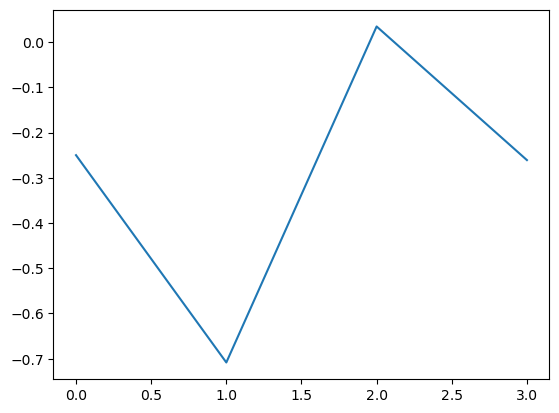

In [12]:
# Visuals
df_visual_pd = df_visual_pd['avg_temperature'].astype(float)
df_visual_pd.plot.line()

In [100]:
# Query sample
df_visual = df_aggr.select(
                    "device_id",
                    df_aggr.window.start.cast("string").alias("start_time"),
                    "avg(temperature)"
                ) \
                .sort('start_time','device_id')

In [101]:
# Rename some cols
df_visual = df_visual.withColumnRenamed('avg(temperature)','avg_temperature')

In [102]:
# To pandas for visualization
df_visual_pd = df_visual.toPandas()

# using dictionary to convert specific columns
convert_dict = {'device_id': str,
                'start_time': str,
                'avg_temperature': float
                }

# df_visual_pd = df_visual_pd['avg_temperature'].astype(float)
df_visual_pd = df_visual_pd.astype(convert_dict)

In [103]:
# Specify the Date as Time index
df_visual_pd_s2 = df_visual_pd.pivot(index='start_time', columns='device_id', values='avg_temperature')

<Axes: xlabel='start_time'>

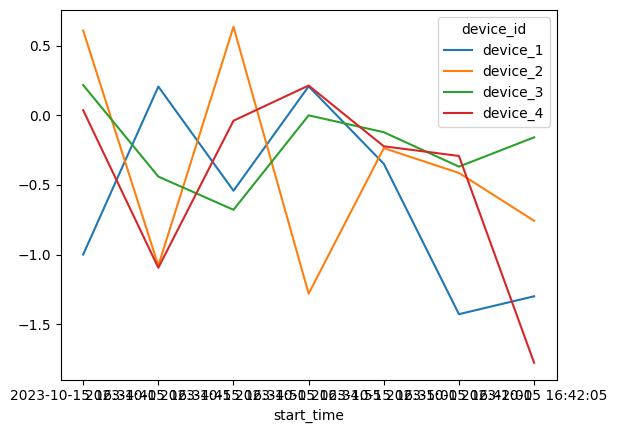

In [104]:
# Visuals
df_visual_pd_s2.plot.line()

In [105]:
# Stop the session
spark.stop()